In [1]:
pip install cufinufft==2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 MB 10.5 MB/s eta 0:00:00


In [2]:
import torch
import cupy as cp
import cufinufft
import numpy as np

In [3]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)

# 1- Sobolev regression

## 1.1- Package

In [4]:
def conjugate_gradient(A_function, b, x0, tol=1e-10, display=True):
    """
    Solves Ax = b using the Conjugate Gradient method.

    Parameters:
        A : function or matrix
            Matrix or function that computes the product Ax.
        b : ndarray
            Right-hand side vector.
        x0 : ndarray
            Initial guess.
        tol : float
            Tolerance for the stopping criterion.
        max_iter : int
            Maximum number of iterations.

    Returns:
        x : ndarray
            Approximate solution to Ax = b.
    """
    m = b.shape[0]

    x = x0
    r = b - A_function(x)
    p = r.clone()
    rs_old = torch.linalg.vector_norm(r)**2

    for i in range(4*m):#A cause de l'embedding pour avoir un circulant: on inverse Cx qui est de taille 3m
        Ap = A_function(p)
        alpha = rs_old / torch.vdot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.linalg.vector_norm(r)**2

        if torch.sqrt(rs_new) < tol:
          if display:
            print(f"CG converged in {i} iterations.")
          break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

In [5]:
import torch

def fast_recursive_block_toeplitz_multiply3(a, U, n):
    device = a.device
    dtype = a.dtype

    frequencies = torch.arange(-(n - 1), n, device=device)
    freq_positive = torch.arange(1, n + 1, device=device)

    # Flatten a into polynomial A(t)
    # Create grid of indices
    I1, I2 = torch.meshgrid(frequencies, frequencies, indexing='ij')
    I1_flat = I1.flatten()
    I2_flat = I2.flatten()

    # Compute flat indices
    h = (n + I1_flat - 1) * (2 * n - 1) + (n + I2_flat - 1)

    # Extract values from `a` and assign to A_coeffs
    A_coeffs = torch.zeros((2 * n - 1) * (2 * n - 1), dtype=dtype, device=device)
    A_coeffs[h] = a[I1_flat + (n - 1), I2_flat + (n - 1)]

    max_h = A_coeffs.shape[0]

    # Flatten U into polynomial U(t)
    j1_grid, j2_grid = torch.meshgrid(freq_positive, freq_positive, indexing='ij')
    l_indices = 2 * n * (n - 1) - (j1_grid - 1) * (2 * n - 1) - (j2_grid - 1)

    max_l = l_indices.max().item()
    U_coeffs = torch.zeros(max_l + 1, dtype=dtype, device=device)
    U_coeffs[l_indices.reshape(-1)] = U.reshape(-1)

    # Pad for FFT
    total_degree = max_h + max_l
    fft_size = 1 << (total_degree - 1).bit_length()

    A_fft = torch.fft.fft(A_coeffs, fft_size)
    U_fft = torch.fft.fft(U_coeffs, fft_size)

    P_fft = A_fft * U_fft
    # Inverse FFT
    P_coeffs = torch.fft.ifft(P_fft)

    # Compute the indices in a vectorized way
    s = 2 * n * (2 * n - 1) - j1_grid * (2 * n - 1) - j2_grid

    # Gather the conjugate values
    D = torch.conj(P_coeffs[s])
    return D.flatten()



def build_full_A(a, n):
    N = n * n
    A = torch.zeros((N, N), dtype=a.dtype, device=a.device)

    index_pairs = [(i1, i2) for i1 in range(n) for i2 in range(n)]
    shift = n - 1

    for row_idx, (i1, i2) in enumerate(index_pairs):
        for col_idx, (j1, j2) in enumerate(index_pairs):
            k1 = i1 - j1
            k2 = i2 - j2
            if -shift <= k1 <= shift and -shift <= k2 <= shift:
                A[row_idx, col_idx] = a[k1 + shift, k2 + shift]
    return A

# Parameters
m = 1
n = 2 * m + 1

# Coefficients a[i1, i2], shape (2n-1, 2n-1)
a = torch.tensor([
    [9.+1j, 8, 7, 8, torch.pi*(1+1j)],
    [6, 5, 4, 5, 6],
    [3, 2, 1, 2, 3],
    [6, 5, 4, 5, 6],
    [torch.pi*(1-1j), 8, 7, 8, 9-1j]
], dtype = torch.complex128)

# Random vector x
x = torch.randn(n * n)*(1.+0*1j)

# Build full matrix A
A = build_full_A(a, n)

# Compare
D1 = A @ x
D2 = fast_recursive_block_toeplitz_multiply3(a, x, n)

print(torch.linalg.norm(D1 - D2))  # Should be very close to zero

tensor(6.3709e-15)


In [6]:
def A_function(x, lambda_n, S_inv, f_tensor, m, device):
  n = x.shape[0]
  #kernel_term = S_inv* fast_recursive_block_toeplitz_multiply3(f_tensor, , 2*m+1)
  rescaled_x_re = torch.real(S_inv * x).to(torch.complex128)
  rescaled_x_im = torch.imag(S_inv * x).to(torch.complex128)
  kernel_term = fast_recursive_block_toeplitz_multiply3(f_tensor, rescaled_x_re, 2*m+1) + 1j* fast_recursive_block_toeplitz_multiply3(f_tensor, rescaled_x_im, 2*m+1)
  return S_inv*kernel_term + lambda_n * x

In [7]:
def NUFFT_Y(x1_gpu, x2_gpu, y_gpu, m, threshold):
  n = x1_gpu.shape[0]

  f_gpu = cufinufft.nufft2d1(x1_gpu, x2_gpu, y_gpu, (2*m+1,2*m+1), eps=threshold)/n

  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor.flatten()

In [8]:
def S_vect_inv(m, s):
  frequencies =  torch.arange(-m, m+1, device=device)
  k1, k2 = torch.meshgrid(*[frequencies]*2, indexing='ij')
  k_norm = k1.flatten()**2+k2.flatten()**2
  return 1/torch.sqrt(1 + k_norm**s)

In [9]:
def kernel_vect(x1_gpu, x2_gpu, m, threshold):
  n = x1_gpu.shape[0]
  y_gpu = cp.ones(n).astype(cp.complex128)

  f_gpu = cufinufft.nufft2d1(x1_gpu, x2_gpu, y_gpu, (4*m+1,4*m+1), eps=threshold)/n#[2*m:, 2*m:]/n
  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor

In [10]:
def FFT_inv(x1_gpu, x2_gpu, nufft, m, s, lambda_n, threshold, display=True):
    f_tensor = kernel_vect(x1_gpu, x2_gpu, m, threshold)
    S_inv = S_vect_inv(m, s)
    A_funct = lambda x: A_function(x, lambda_n, S_inv, f_tensor,m, device)

    x0 = nufft.clone()
    inv = conjugate_gradient(A_funct, nufft, x0, tol=threshold, display=display)
    if display:
      print("Error CG ", torch.linalg.norm(A_funct(inv) - nufft))
    return S_inv * inv

In [11]:
def NUFFT_inv(x1_gpu, x2_gpu, f_gpu, m, threshold):
  n = x1_gpu.shape[0]

  y_estimated = cufinufft.nufft2d2(x1_gpu, x2_gpu, f_gpu.view(2*m+1, 2*m+1), eps=threshold)

  y_estimated = torch.utils.dlpack.from_dlpack(y_estimated)

  return y_estimated

## 1.2 Dependency in $s$ for classical sobolev kernel

In [12]:
s_list = np.array([1+i/4 for i in range(36)])
train_lists = []

powers = np.arange(1, 9)
d = 2
n_samples = 10
threshold = 10e-10

N_test = 10**4
x1_test = cp.random.uniform(size=N_test).astype(cp.float64)
x2_test = cp.random.uniform(size=N_test).astype(cp.float64)
y_test = (cp.exp(x1_test)*cp.cos(x2_test)).astype(cp.complex128)

for power in powers:
  print(power, "/", powers[-1])
  print("\n\n")

  N = 10**power
  training_error = np.array([])
  sob = np.array([])

  for s in s_list:
    mse_mean = 0
    for samples in range(n_samples):
      x1_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      x2_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      y_gpu =  (cp.exp(x1_gpu)*cp.cos(x2_gpu)).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)

      lambda_n= N**(-(2*s)/(2*s+d))
      m =  int(N**(1/(2*s+d)))

      S_inv = S_vect_inv(m, s)

      cov_y = S_inv*NUFFT_Y(x1_gpu, x2_gpu, y_gpu, m, threshold)
      hat_theta =  FFT_inv(x1_gpu, x2_gpu, cov_y, m, s, lambda_n, threshold, display=False)

      estimator = torch.real(NUFFT_inv(x1_test, x2_test, hat_theta, m, threshold))

      error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
      mse = torch.mean(torch.square(torch.abs(error)))
      mse_mean +=mse

    mse_mean /=n_samples

    training_error = np.append(training_error, mse_mean)
  train_lists.append(training_error)
print("Done!")

1 / 8





/tmp/ipython-input-2403113023.py:39: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)


2 / 8



3 / 8



4 / 8



5 / 8



6 / 8



7 / 8



8 / 8



Done!


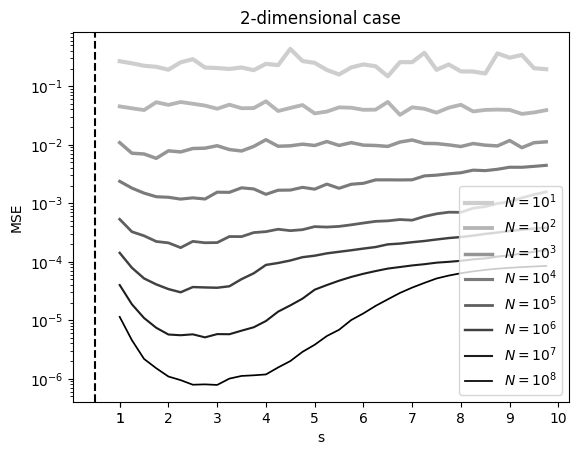

In [13]:
import matplotlib.pyplot as plt

colors = plt.cm.Greys(np.linspace(0.3, 1, len(powers)))

for i in range(len(powers)):
  plt.plot(s_list, train_lists[i], label = '$N = 10^'+str(powers[i])+'$',
           color = colors[i], linewidth= 3 - 0.25*i)
plt.yscale('log')
plt.xlabel("s")
plt.xticks(np.arange(0, 11, 1))
plt.ylabel("MSE")
plt.title("2-dimensional case")

plt.axvline(x=1, color="black",linestyle='--')
xticks = plt.xticks()[0]  # Get current x-tick locations
if 0.5 not in xticks:
    plt.xticks(list(xticks) + [1])  # Add 0.5 to the list

plt.legend(loc='lower right')
plt.plot()
plt.savefig('2d-Sob.pdf')


## 1.3 low-bias kernel

In [14]:
s_list = np.array([1+i/4 for i in range(36)])
train_lists = []

powers = np.arange(1, 9)
d = 2
n_samples = 10
threshold = 10e-10

N_test = 10**4
x1_test = cp.random.uniform(size=N_test).astype(cp.float64)
x2_test = cp.random.uniform(size=N_test).astype(cp.float64)
y_test = (cp.exp(x1_test)*cp.cos(x2_test)).astype(cp.complex128)

for power in powers:
  print(power, "/", powers[-1])
  print("\n\n")

  N = 10**power
  training_error = np.array([])
  sob = np.array([])

  for s in s_list:
    mse_mean = 0
    for samples in range(n_samples):
      x1_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      x2_gpu =  cp.random.uniform(size=N).astype(cp.float64)
      y_gpu =  (cp.exp(x1_gpu)*cp.cos(x2_gpu)).astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)

      lambda_n= N**(-(2*s)/(2*s+d))#/norm
      m =  int(N**(1/(2*s+d)))

      S_inv = S_vect_inv(m, 0)

      cov_y = S_inv*NUFFT_Y(x1_gpu, x2_gpu, y_gpu, m, threshold)
      hat_theta =  FFT_inv(x1_gpu, x2_gpu, cov_y, m, 0, lambda_n, threshold, display=False)

      estimator = torch.real(NUFFT_inv(x1_test, x2_test, hat_theta, m, threshold))

      error = torch.real(estimator.cpu()) - torch.tensor(y_test.get(), dtype=torch.float64)
      mse = torch.mean(torch.square(torch.abs(error)))
      mse_mean +=mse

    mse_mean /=n_samples

    training_error = np.append(training_error, mse_mean)
  train_lists.append(training_error)
print("Done!")

1 / 8



2 / 8



3 / 8



4 / 8



5 / 8



6 / 8



7 / 8



8 / 8



Done!


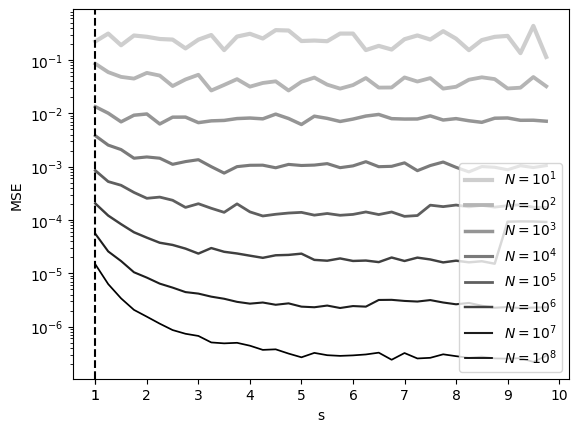

In [17]:
import matplotlib.pyplot as plt

colors = plt.cm.Greys(np.linspace(0.3, 1, len(powers)))

for i in range(len(powers)):
  plt.plot(s_list, train_lists[i], label = '$N = 10^'+str(powers[i])+'$',
           color = colors[i], linewidth= 3 - 0.25*i)
plt.yscale('log')
plt.xlabel("s")
plt.xticks(np.arange(0, 11, 1))
plt.ylabel("MSE")

plt.axvline(x=1, color="black",linestyle='--')
xticks = plt.xticks()[0]  # Get current x-tick locations
if 0.5 not in xticks:
    plt.xticks(list(xticks) + [1])  # Add 0.5 to the list

plt.legend(loc='lower right')
plt.plot()
plt.savefig('2d-restrained.pdf')
